# **MLP - Multi-class Weather Dataset**

- https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset
- Sunrise 357, Shine 253, Rain 215, Cloudy 300

## [Step 01] 라이브러리 로딩

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split

import matplotlib.pyplot as plt
import matplotlib.image as image
import numpy as np

## [Step 02] 데이터셋 로딩

- GitHub를 통해 데이터셋 다운로드: https://github.com/hmjeon/Lec-DLCV/
- 데이터셋 저장위치: dataset/dataset_weather

In [2]:
!git clone https://github.com/hmjeon/Lec-DLCV/
%cd Lec-DLCV/dataset/dataset_weather/

Cloning into 'Lec-DLCV'...
remote: Enumerating objects: 1572, done.
remote: Counting objects: 100% (446/446), done.
remote: Compressing objects: 100% (422/422), done.
remote: Total 1572 (delta 30), reused 437 (delta 22), pack-reused 1126
Receiving objects: 100% (1572/1572), 185.38 MiB | 35.79 MiB/s, done.
Resolving deltas: 100% (34/34), done.
/content/Lec-DLCV/dataset/dataset_weather


데이터 변형
- 학습데이터에서 Data augmentation 진행
- 이미지 사이즈 병형 256 by 256
- 이미지 정규화 진행: 데이터가 유사한 범위를 가질 수 있도록 변형
  - transforms.ToTensor()만 적용한 경우, 모든 이미지의 픽셀 값이 0~1의 범위를 가지도록 변환
  - transofrms.Normalize()는 각 채널별 평균(mean)을 뺀 뒤 표준편차(std)로 나누어 정규화

In [3]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

transform_val = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

DataLoader() 함수를 활용한 데이터 로딩
- 어떤 데이터를 사용할 것인지, 배치 크기(batch size), 데이터 셔플(shuffle) 여부 등을 명시
- next() 함수를 이용하여 tensor 형태로 데이터를 배치 단위로 얻을 수 있음

In [4]:
# 학습용 데이터셋 -> 학습용 + 검증용
train_dataset = datasets.ImageFolder(
    root='train/',
    transform=transform_train
)

# 데이터 사이즈 => 학습용 : 검증용 = 8 : 2
dataset_size = len(train_dataset)
train_size = int(dataset_size * 0.8)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# 테스트 데이터셋
test_dataset = datasets.ImageFolder(
    root='test/',
    transform=transform_test
)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

## [Step 03] 데이터 가시화

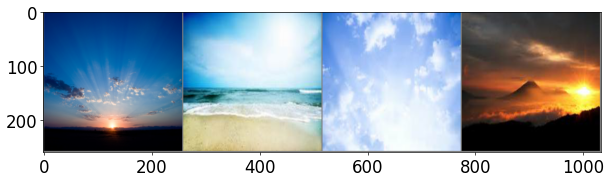

['Sunrise', 'Shine', 'Shine', 'Sunrise']


In [8]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})

def imshow(input):
    # Convert Tensor to numpy arrary
    # torch의 경우 CxHxW, numpy의 경우 HxWxC
    input = input.numpy().transpose((1, 2, 0))

    # Undo image normalization
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    input = std * input + mean
    input = np.clip(input, 0, 1)

    # Display images
    plt.imshow(input)
    plt.show()

    
class_names = {
  0: "Cloudy",
  1: "Rain",
  2: "Shine",
  3: "Sunrise"
}

# iter 및 next 함수: iter는 객체의 __iter__ 메서드를 호출, next는 객체의 __next__메서드를 호출
# iter는 반복 가능한 객체에서 이터레이터를 반환하고, next는 이터레이터에서 값을 차례대로 꺼냄

# Load a batch of train image
iterator = iter(train_dataloader)

# Visualize a batch of train image
imgs, labels = next(iterator)
imgs, labels = next(iterator)
out = torchvision.utils.make_grid(imgs[:4])
imshow(out)
print([class_names[labels[i].item()] for i in range(4)])

## [Step 04] MLP 모델 정의

- 직접 정의한 뉴럴 네트워크를 활용하여 데이터셋 학습 진행
- 레이어 깊이를 증가하면서 네트워크 모델을 변경

In [9]:
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        self.linear1 = nn.Linear(256 * 256 * 3, 4)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        return x


class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        self.linear1 = nn.Linear(256 * 256 * 3, 64)
        self.linear2 = nn.Linear(64, 4)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.linear2(x)
        return x


class Model3(nn.Module):
    def __init__(self):
        super(Model3, self).__init__()
        self.linear1 = nn.Linear(256 * 256 * 3, 128)
        self.dropout1 = nn.Dropout(0.5)
        self.linear2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.linear3 = nn.Linear(64, 32)
        self.dropout3 = nn.Dropout(0.5)
        self.linear4 = nn.Linear(32, 4)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.linear1(x))
        x = self.dropout1(x)
        x = F.relu(self.linear2(x))
        x = self.dropout2(x)
        x = F.relu(self.linear3(x))
        x = self.dropout3(x)
        x = self.linear4(x)
        return x

In [13]:
import time

# 모델 학습을 위함 함수
def train():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')
    model.train()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(train_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        outputs = model(imgs)
        optimizer.zero_grad()
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        
        if i % log_step == log_step - 1:
            print(f'[Batch: {i + 1}] running train loss: {running_loss / total}, running train accuracy: {running_corrects / total}')

    print(f'train loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

# 모델 검증을 위함 함수
def validate():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Validation]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(val_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running val loss: {running_loss / total}, running val accuracy: {running_corrects / total}')

    print(f'val loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

# 모델 테스트를 위함 함수
def test():
    start_time = time.time()
    print(f'[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(test_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

In [14]:
import time

def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 3:
        lr /= 10
    if epoch >= 7:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

## [Step 05] 네트워크 학습

- 학습 결과 시각화

In [ ]:
learning_rate = 0.01
log_step = 20

model = Model1()
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

num_epochs = 20
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []
for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train()
    val_loss, val_acc = validate()
    history.append((train_loss, val_loss))
    accuracy.append((train_acc, val_acc))

    if val_acc > best_val_acc:
        print("[Info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), f"best_checkpoint_epoch_{epoch + 1}.pth")

torch.save(model.state_dict(), f"last_checkpoint_epoch_{num_epochs}.pth")

plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

test_loss, test_accuracy = test()
print(f"Test loss: {test_loss:.8f}")
print(f"Test accuracy: {test_accuracy * 100.:.2f}%")

In [ ]:
learning_rate = 0.01
log_step = 20

model = Model2()
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

num_epochs = 20
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []
for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train()
    val_loss, val_acc = validate()
    history.append((train_loss, val_loss))
    accuracy.append((train_acc, val_acc))

    if val_acc > best_val_acc:
        print("[Info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), f"best_checkpoint_epoch_{epoch + 1}.pth")

torch.save(model.state_dict(), f"last_checkpoint_epoch_{num_epochs}.pth")

plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

test_loss, test_accuracy = test()
print(f"Test loss: {test_loss:.8f}")
print(f"Test accuracy: {test_accuracy * 100.:.2f}%")

In [ ]:
learning_rate = 0.01
log_step = 20

model = Model3()
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

num_epochs = 20
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []
for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train()
    val_loss, val_acc = validate()
    history.append((train_loss, val_loss))
    accuracy.append((train_acc, val_acc))

    if val_acc > best_val_acc:
        print("[Info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), f"best_checkpoint_epoch_{epoch + 1}.pth")

torch.save(model.state_dict(), f"last_checkpoint_epoch_{num_epochs}.pth")

plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

test_loss, test_accuracy = test()
print(f"Test loss: {test_loss:.8f}")
print(f"Test accuracy: {test_accuracy * 100.:.2f}%")